# West Coast Fire Prediction
Narrowing down the scope of project-5 to just California, Oregon, and Washington for now.

# Functions

In [742]:
# function-in-progress

def add_state(data_list, state_abb, data_start):
    '''
    This function takes in a list of paths to data, and does
    a ton of the preprocessing and data wrangling. 
    
    data_list (list): this is a list of the paths to the data,
        in the form ['temp_path', 'precip_path']
    state_abb (str): the 2-letter state abbreviation.
    data_start (str): the year that we want to start data collection.
    
    Returns state_fires, state_climate dataframes
    '''
    
    # getting temp and precip data ready
    temp = climate_preprocessor_v2(path=data_list[0],
                                   state=state_abb,
                                   metric='temp',
                                   start_yr=data_start,
                                   end_yr='2015')
    
    precip = climate_preprocessor_v2(path=data_list[1],
                                   state=state_abb,
                                   metric='precip',
                                   start_yr=data_start,
                                   end_yr='2015')
    
    
    climate = pd.merge(temp, precip, on = 'FIPS_YEAR')
    
    return climate
    # 
    # # importing fire data from the state
    # con = sqlite3.connect("/Users/patricknorman/Downloads/FPA_FOD_20170508.sqlite")
# 
    # query = f'SELECT FIRE_NAME, FIRE_YEAR, FIRE_SIZE, STATE, COUNTY, FIPS_CODE, FIPS_NAME FROM Fires WHERE State = {state};'
    # 
    # state_fires = pd.read_sql_query(query, con)
# 
    # con.close()
    # 
    # # filtering by year
    # filter_ = (state_fires['FIRE_YEAR'].apply(lambda x: int(x)) >= data_start)
    # state_fires = state_fires[filter_]
    # 
    # # creating and formatting columns
    # state_fires = state_fires.rename(columns={'FIPS_CODE':'COUNTY_CODE'})
    # state_fires['STATE_CODE'] = state_fires.STATE.apply(lambda x: state_codes[x])
    # state_fires = state_fires.astype({'COUNTY_CODE':'str'})
    # state_fires['FIPS'] = state_fires.STATE_CODE + state_fires.COUNTY_CODE
    # state_fires = state_fires[state_fires.COUNTY_CODE != 'None']
    # state_fires['FIPS-YEAR'] = state_fires['FIPS'] + ' ' + state_fires['FIRE_YEAR'].apply(lambda x: str(x))
    # 
    # # grouping by fips-year
    # state_fires = pd.DataFrame(state_fires.groupby(['FIPS-YEAR'])['FIRE_SIZE'].sum())
    # state_fires = state_fires.reset_index()
    # 
    # return state_fires, climate

In [743]:
def county_visualizer(df, metric, colorscale = 'thermal'):
    '''
    Given a dataframe, a metric to visualize, this function returns a map of the counties of the US based on
    whatever metric you passed. 
    
    df: pandas dataframe to get the data from.
    metric (str): the name of the column in df that you want to visualize by county. 
    colorscale (str): the name of the built-in color scale you want to use. Defaults to the thermal scale.
    
    '''
    
    # importing shapefiles for US counties
    from urllib.request import urlopen
    import json
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)

    # plotting figure
    import plotly.express as px

    fig = px.choropleth(df, geojson=counties, locations='FIPS', color=metric,
                               color_continuous_scale=colorscale,
                               scope="usa")
    
    fig.show()

In [744]:
def fireyear_plotter(df, year, colorscale = 'thermal'):
    '''
    Given a dataframe, a year to visualize (between 1991 and 2015), this function returns 
    a map of the US by county with the number of acres burned in that year due to 
    wildfire.
    
    df: pandas dataframe to get the fire data from.
    year (str): the year to examine.
    colorscale (str): the name of the built-in color scale you want to use. Defaults to the thermal scale.
    '''
    
    
    # importing shapefiles for US counties
    from urllib.request import urlopen
    import json
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)
        
    # filtering df by year
    year_df = df[df['YEAR'] == year]

    # plotting figure
    import plotly.express as px

    fig = px.choropleth(year_df, geojson=counties, locations='FIPS', color='FIRE_SIZE',
                               color_continuous_scale=colorscale,
                               scope="usa")
    
    fig.show()

In [745]:
def climate_preprocessor(path, statecode, value_label, rank_label, anomaly_label, mean_label):
    '''
    Given a file path and the new labels for the data, this function creates a Pandas dataframe, 
    removes dates outside of the 1998-2015 range, and formats
    the columns for combination by changing labels and adding FIPS. 
    '''
    
    df = pd.read_csv(path)
    
    df = df.rename(columns={'Value':value_label,'Rank':rank_label,'Anomaly (1901-2000 base period)':anomaly_label, '1901-2000 Mean':mean_label, 'Location ID':'FIPS'})
    
    df = df[df['Date'] >= 199801]
    df = df[df['Date'] <= 201512]
    
    df['YEAR'] = df['Date'].apply(lambda x: str(x)[:4])
    
    df['FIPS'] = df['FIPS'].apply(lambda x: statecode+x[3:])
    
    df['FIPS-YEAR'] = df['FIPS'] + ' ' + df['YEAR']
    
    df = df.groupby(['FIPS-YEAR']).mean()
    
    df = df.reset_index()
    
    df = df.drop(columns='Date')
    
    return df

In [746]:
def climate_preprocessor_v2(path, state, metric, start_yr, end_yr):
    '''
    This function takes NOAA data from a given state, and
    preprocesses it in the way that I need to for this project.
    
    path (str): the file path for the data.
    state (str): the 2 digit state abbreviation for FIPS creation.
    metric (str): either 'precip' or 'temp'.
    start_yr (str): the first year for data collection.
    end_yr (str): the final year for data collection.
    
    '''
    # reading in data
    df = pd.read_csv(path)
    
    # labeling data
    if metric == 'precip':
        df = df.rename(columns={'Value':'precip','Rank':'precip_rank','Anomaly (1901-2000 base period)':'precip_anomaly', '1901-2000 Mean':'precip_mean', 'Location ID':'FIPS'})
    
    else:
        df = df.rename(columns={'Value':'temp','Rank':'temp_rank','Anomaly (1901-2000 base period)':'temp_anomaly', '1901-2000 Mean':'temp_mean', 'Location ID':'FIPS'})
    
    # filtering by date
    start_yr = start_yr + '01'
    end_yr = end_yr + '12'
    
    df = df[df['Date'] >= int(start_yr)]
    df = df[df['Date'] <= int(end_yr)]
    
    # creating some new columns
    df['YEAR'] = df['Date'].apply(lambda x: str(x)[:4])
    df['FIPS'] = df['FIPS'].apply(lambda x: state_codes[state]+x[3:])
    df['FIPS-YEAR'] = df['FIPS'] + ' ' + df['YEAR']
    
    # grouping by fips-year
    df = df.groupby(['FIPS-YEAR']).mean()
    
    # cleaning up
    df = df.reset_index()
    df = df.drop(columns='Date')
    
    return df

In [747]:
def randomforest_tweak(hyperparameter, min_, max_):
    '''
    This function takes a range for a Random Forest parameter,
    and plots the % of variation explained during validation.
    
    hyperparameter (str): the hyperparameter to investigate.
        can be 
    min_ (int): the minimum hyperparameter value.
    max_ (int): the max hyperparameter value.
    
    '''
    var_explained = []
    i_list = []
    
    if hyperparameter == 'n_estimators':
        for i in range(min_, max_):
            rf = RandomForestRegressor(n_estimators = i)

            rf.fit(x_train, y_train)
            rf_pred = rf.predict(x_val)

            var_explained.append(explained_variance_score(y_val, rf_pred)*100)
            i_list.append(i)
            
    if hyperparameter == 'max_depth':
        for i in range(min_, max_):
            rf = RandomForestRegressor(n_estimators = i)

            rf.fit(x_train, y_train)
            rf_pred = rf.predict(x_val)

            var_explained.append(explained_variance_score(y_val, rf_pred)*100)
            i_list.append(i)
        
    plt.plot(i_list, var_explained)
    plt.title('% Variation Explained During Validation')
    plt.xlabel('Hyperparameter value')
    plt.ylabel('% Var Explained')

# Packages

In [748]:
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Wildfire Data Import and Cleaning

In [749]:
con = sqlite3.connect("/Users/patricknorman/Downloads/FPA_FOD_20170508.sqlite")

cur = con.cursor()
        
all_fires = pd.read_sql_query('SELECT FIRE_NAME, FIRE_YEAR, FIRE_SIZE, STATE, COUNTY, FIPS_CODE, FIPS_NAME  FROM Fires;', con)

# Be sure to close the connection
con.close()

In [750]:
all_fires.head()

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,FOUNTAIN,2005,0.10,CA,63,063,Plumas
1,PIGEON,2004,0.25,CA,61,061,Placer
2,SLACK,2004,0.10,CA,17,017,El Dorado
3,DEER,2004,0.10,CA,3,003,Alpine
4,STEVENOT,2004,0.10,CA,3,003,Alpine


In [751]:
all_fires = all_fires.rename(columns={'FIPS_CODE':'COUNTY_CODE'})

state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

all_fires['STATE_CODE'] = all_fires.STATE.apply(lambda x: state_codes[x])
all_fires = all_fires.astype({'COUNTY_CODE':'str'})
all_fires['FIPS'] = all_fires.STATE_CODE + all_fires.COUNTY_CODE
all_fires = all_fires[all_fires.COUNTY_CODE != 'None']

all_fires.head()

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,STATE,COUNTY,COUNTY_CODE,FIPS_NAME,STATE_CODE,FIPS
0,FOUNTAIN,2005,0.10,CA,63,063,Plumas,06,06063
1,PIGEON,2004,0.25,CA,61,061,Placer,06,06061
2,SLACK,2004,0.10,CA,17,017,El Dorado,06,06017
3,DEER,2004,0.10,CA,3,003,Alpine,06,06003
4,STEVENOT,2004,0.10,CA,3,003,Alpine,06,06003


# Filtering Down to West Coast States

# EDIT THIS CELL WHEN ADDING STATES

In [752]:
wa_filter = (all_fires['FIRE_YEAR'].apply(lambda x: int(x)) >= 1998) & (all_fires['STATE'] == 'WA')
wa_fires = all_fires[wa_filter ]

ca_filter = (all_fires['FIRE_YEAR'].apply(lambda x: int(x)) >= 1998) & (all_fires['STATE'] == 'CA')
ca_fires = all_fires[ca_filter ]

or_filter = (all_fires['FIRE_YEAR'].apply(lambda x: int(x)) >= 1998) & (all_fires['STATE'] == 'OR')
or_fires = all_fires[or_filter ]

nv_filter = (all_fires['FIRE_YEAR'].apply(lambda x: int(x)) >= 1998) & (all_fires['STATE'] == 'NV')
nv_fires = all_fires[nv_filter]

ut_filter = (all_fires['FIRE_YEAR'].apply(lambda x: int(x)) >= 1998) & (all_fires['STATE'] == 'UT')
ut_fires = all_fires[ut_filter]

westcoast_fires = pd.concat([wa_fires, ca_fires, or_fires, nv_fires, ut_fires])

In [753]:
ut_fires.isna().value_counts()

FIRE_NAME  FIRE_YEAR  FIRE_SIZE  STATE  COUNTY  COUNTY_CODE  FIPS_NAME  STATE_CODE  FIPS 
False      False      False      False  False   False        False      False       False    17344
True       False      False      False  False   False        False      False       False     2587
dtype: int64

In [754]:
westcoast_fires.STATE.value_counts()

CA    56195
OR    34220
UT    19931
WA    19080
NV    10929
Name: STATE, dtype: int64

# Grouping Fires by FIPS-Year

In [755]:
westcoast_fires['FIPS-YEAR'] = westcoast_fires['FIPS'] + ' ' + westcoast_fires['FIRE_YEAR'].apply(lambda x: str(x))
fires = pd.DataFrame(westcoast_fires.groupby(['FIPS-YEAR','STATE'])['FIRE_SIZE'].sum())
fires = fires.reset_index()

# Importing and Processing West Coast Climate Data
I also had to add in counties that were missing from the dataset due to no wildfires occuring during a given year. 

In [756]:
ca_precip = climate_preprocessor('/Users/patricknorman/Downloads/ca_precip.csv',
                                 '06',
                                 'precip',
                                 'precip_rank',
                                 'precip_anomaly',
                                 'precip_mean')

ca_temp = climate_preprocessor('/Users/patricknorman/Downloads/4-tavg.csv',
                               '06',
                               'temp',
                               'temp_rank',
                               'temp_anomaly',
                               'temp_mean')

In [757]:
or_temp = climate_preprocessor('/Users/patricknorman/Downloads/or_temp.csv',
                               '41',
                               'temp',
                               'temp_rank',
                               'temp_anomaly',
                               'temp_mean')

or_precip = climate_preprocessor('/Users/patricknorman/Downloads/35-pcp.csv',
                                 '41',
                                 'precip',
                                 'precip_rank',
                                 'precip_anomaly',
                                 'precip_mean')

In [758]:
wa_temp = climate_preprocessor('/Users/patricknorman/Downloads/45-tavg.csv',
                               '53',
                               'temp',
                               'temp_rank',
                               'temp_anomaly',
                               'temp_mean')

wa_precip = climate_preprocessor('/Users/patricknorman/Downloads/45-pcp.csv',
                                 '53',
                                 'precip',
                                 'precip_rank',
                                 'precip_anomaly',
                                 'precip_mean')

In [759]:
nv_temp = climate_preprocessor_v2('/Users/patricknorman/Downloads/26-tavg.csv',
                                  'NV',
                                  'temp',
                                  '1998',
                                  '2015')

nv_precip = climate_preprocessor_v2('/Users/patricknorman/Downloads/26-pcp.csv',
                                  'NV',
                                  'precip',
                                  '1998',
                                  '2015')

In [760]:
ut_temp = climate_preprocessor_v2('/Users/patricknorman/Downloads/42-tavg.csv',
                                  'UT',
                                  'temp',
                                  '1998',
                                  '2015')

ut_precip = climate_preprocessor_v2('/Users/patricknorman/Downloads/42-pcp.csv',
                                  'UT',
                                  'precip',
                                  '1998',
                                  '2015')

# EDIT THIS CELL WHEN ADDING STATES

In [761]:
ca_climate = pd.merge(ca_temp, ca_precip, on = 'FIPS-YEAR')
or_climate = pd.merge(or_temp, or_precip, on = 'FIPS-YEAR')
wa_climate = pd.merge(wa_temp, wa_precip, on = 'FIPS-YEAR')
nv_climate = pd.merge(nv_temp, nv_precip, on = 'FIPS-YEAR')
ut_climate = pd.merge(ut_temp, ut_precip, on = 'FIPS-YEAR')

westcoast_climate = pd.concat([wa_climate, or_climate, ca_climate, nv_climate, ut_climate])

In [823]:
nv_climate

,FIPS-YEAR,temp,temp_rank,temp_anomaly,temp_mean,precip,precip_rank,precip_anomaly,precip_mean
0,32001 1998,50.416667,60.916667,-0.033333,50.45,1.085833,89.666667,0.529167,0.556667
1,32001 1999,51.458333,71.083333,1.008333,50.45,0.328333,46.500000,-0.228333,0.556667
2,32001 2000,52.333333,82.500000,1.883333,50.45,0.579167,70.666667,0.022500,0.556667
3,32001 2001,52.658333,88.416667,2.208333,50.45,0.411667,53.833333,-0.145000,0.556667
4,32001 2002,51.666667,74.916667,1.216667,50.45,0.277500,46.500000,-0.279167,0.556667
...,...,...,...,...,...,...,...,...,...
301,32510 2011,48.408333,55.250000,-0.391667,48.80,0.950000,55.500000,-0.311667,1.261667
302,32510 2012,51.150000,91.500000,2.350000,48.80,1.070833,57.416667,-0.190833,1.261667
303,32510 2013,49.916667,75.250000,1.116667,48.80,0.430000,44.166667,-0.831667,1.261667
304,32510 2014,52.558333,109.333333,3.758333,48.80,0.968333,64.333333,-0.293333,1.261667


In [762]:
ut_climate.tail()

,FIPS-YEAR,temp,temp_rank,temp_anomaly,temp_mean,precip,precip_rank,precip_anomaly,precip_mean
517,49057 2011,44.800000,61.583333,0.116667,44.683333,2.710000,79.833333,0.471667,2.238333
518,49057 2012,48.558333,105.166667,3.875000,44.683333,1.786667,51.333333,-0.451667,2.238333
519,49057 2013,45.658333,75.500000,0.975000,44.683333,1.480833,42.250000,-0.757500,2.238333
520,49057 2014,47.725000,94.000000,3.041667,44.683333,2.370000,72.583333,0.131667,2.238333
521,49057 2015,48.858333,94.583333,4.175000,44.683333,2.115833,60.833333,-0.122500,2.238333


In [763]:
westcoast_climate.tail()

,FIPS-YEAR,temp,temp_rank,temp_anomaly,temp_mean,precip,precip_rank,precip_anomaly,precip_mean
517,49057 2011,44.800000,61.583333,0.116667,44.683333,2.710000,79.833333,0.471667,2.238333
518,49057 2012,48.558333,105.166667,3.875000,44.683333,1.786667,51.333333,-0.451667,2.238333
519,49057 2013,45.658333,75.500000,0.975000,44.683333,1.480833,42.250000,-0.757500,2.238333
520,49057 2014,47.725000,94.000000,3.041667,44.683333,2.370000,72.583333,0.131667,2.238333
521,49057 2015,48.858333,94.583333,4.175000,44.683333,2.115833,60.833333,-0.122500,2.238333


# Inserting Missing FIPS-YEARS into the fires df

In [764]:
# creating list of all FIPS-YEAR combos for California

ca_fips = [num for num in (range(116))]


for i in range(len(ca_fips)):
    ca_fips[i] = str(ca_fips[i])
    
    while len(ca_fips[i]) < 3:
        ca_fips[i] = '0' + ca_fips[i]
        
    ca_fips[i] = '06'+ ca_fips[i] 
    
ca_fips = ca_fips[1::2]

In [765]:
# creating list of all FIPS-YEAR combos for Oregon

or_fips = [num for num in range(72)]


for i in range(len(or_fips)):
    or_fips[i] = str(or_fips[i])
    
    while len(or_fips[i]) < 3:
        or_fips[i] = '0' + or_fips[i]
        
    or_fips[i] = '41'+ or_fips[i] 
    
or_fips = or_fips[1::2]

In [766]:
# creating list of all FIPS-YEAR combos for Washington

wa_fips = [num for num in range(78)]


for i in range(len(wa_fips)):
    wa_fips[i] = str(wa_fips[i])
    
    while len(wa_fips[i]) < 3:
        wa_fips[i] = '0' + wa_fips[i]
        
    wa_fips[i] = '53'+ wa_fips[i] 
    
wa_fips = wa_fips[1::2]

In [767]:
# creating list of all FIPS-YEAR combos for Nevada

nv_fips = [num for num in range(34)]

nv_fips.append(510) # I have to append 510 to cover Carson City. 
nv_fips.append(510) # Gotta do it twice to avoid being removed as I remove evens

for i in range(len(nv_fips)):
    nv_fips[i] = str(nv_fips[i])
    
    while len(nv_fips[i]) < 3:
        nv_fips[i] = '0' + nv_fips[i]
        
    nv_fips[i] = '32'+ nv_fips[i] 
    
nv_fips = nv_fips[1::2]

nv_fips

['32001',
 '32003',
 '32005',
 '32007',
 '32009',
 '32011',
 '32013',
 '32015',
 '32017',
 '32019',
 '32021',
 '32023',
 '32025',
 '32027',
 '32029',
 '32031',
 '32033',
 '32510']

In [768]:
# creating list of all FIPS-YEAR combos for Utah

ut_fips = [num for num in range(58)]

for i in range(len(ut_fips)):
    ut_fips[i] = str(ut_fips[i])
    
    while len(ut_fips[i]) < 3:
        ut_fips[i] = '0' + ut_fips[i]
        
    ut_fips[i] = '49'+ ut_fips[i] 
    
ut_fips = ut_fips[1::2]

In [769]:
# combining fips lists for west coast states

state_fips = list()

state_fips.append(ca_fips)


state_fips.append(wa_fips)
state_fips.append(or_fips)
state_fips.append(nv_fips)
state_fips.append(ut_fips)

#state_fips

In [770]:
# flattening list of fips

westcoast_fips = []
for state in state_fips:
    for fips in state:
        westcoast_fips.append(fips)
        
# creating fips-year combinations

fips_years = []

year_list = list(range(1998,2016))
year_list = [str(yr) for yr in year_list]

for fip in westcoast_fips:
    for year in year_list:
        fips_years.append(fip + ' ' + year)

In [771]:
# creating missing fips-year observations
from collections import defaultdict

missing_obs = dict()

for fipyear in fips_years:
    # print(fipyear)
    if fipyear not in list(fires['FIPS-YEAR']):
        print(fipyear, 'not in list')
        if fipyear[:2] == '53':
            missing_obs[fipyear] = ['WA', 0]
        if fipyear[:2] == '06':
            missing_obs[fipyear] = ['CA', 0]
        if fipyear[:2] == '41':
            missing_obs[fipyear] = ['OR', 0]
        if fipyear[:2] == '49':
            missing_obs[fipyear] = ['UT', 0]
        if fipyear[:2] == '32':
            missing_obs[fipyear] = ['NV', 0]
    
missing_obs

06001 2000 not in list
06001 2008 not in list
06001 2009 not in list
06001 2010 not in list
06003 1998 not in list
06013 1998 not in list
06013 2000 not in list
06013 2001 not in list
06013 2008 not in list
06013 2009 not in list
06013 2010 not in list
06015 1998 not in list
06015 2000 not in list
06021 1999 not in list
06021 2000 not in list
06021 2001 not in list
06021 2004 not in list
06021 2005 not in list
06025 1998 not in list
06031 1998 not in list
06031 1999 not in list
06031 2000 not in list
06031 2002 not in list
06031 2003 not in list
06031 2008 not in list
06031 2009 not in list
06031 2010 not in list
06037 1998 not in list
06037 2004 not in list
06041 1998 not in list
06041 1999 not in list
06041 2000 not in list
06041 2001 not in list
06041 2002 not in list
06041 2003 not in list
06041 2005 not in list
06041 2006 not in list
06041 2007 not in list
06041 2009 not in list
06041 2010 not in list
06047 1998 not in list
06047 2000 not in list
06047 2002 not in list
06047 2004 

{'06001 2000': ['CA', 0],
 '06001 2008': ['CA', 0],
 '06001 2009': ['CA', 0],
 '06001 2010': ['CA', 0],
 '06003 1998': ['CA', 0],
 '06013 1998': ['CA', 0],
 '06013 2000': ['CA', 0],
 '06013 2001': ['CA', 0],
 '06013 2008': ['CA', 0],
 '06013 2009': ['CA', 0],
 '06013 2010': ['CA', 0],
 '06015 1998': ['CA', 0],
 '06015 2000': ['CA', 0],
 '06021 1999': ['CA', 0],
 '06021 2000': ['CA', 0],
 '06021 2001': ['CA', 0],
 '06021 2004': ['CA', 0],
 '06021 2005': ['CA', 0],
 '06025 1998': ['CA', 0],
 '06031 1998': ['CA', 0],
 '06031 1999': ['CA', 0],
 '06031 2000': ['CA', 0],
 '06031 2002': ['CA', 0],
 '06031 2003': ['CA', 0],
 '06031 2008': ['CA', 0],
 '06031 2009': ['CA', 0],
 '06031 2010': ['CA', 0],
 '06037 1998': ['CA', 0],
 '06037 2004': ['CA', 0],
 '06041 1998': ['CA', 0],
 '06041 1999': ['CA', 0],
 '06041 2000': ['CA', 0],
 '06041 2001': ['CA', 0],
 '06041 2002': ['CA', 0],
 '06041 2003': ['CA', 0],
 '06041 2005': ['CA', 0],
 '06041 2006': ['CA', 0],
 '06041 2007': ['CA', 0],
 '06041 2009

In [772]:
fires.head()

,FIPS-YEAR,STATE,FIRE_SIZE
0,06001 1998,CA,0.1
1,06001 1999,CA,0.4
2,06001 2001,CA,0.2
3,06001 2002,CA,0.3
4,06001 2003,CA,1.2


In [773]:
# formatting new observations

obs_df = pd.DataFrame.from_dict(missing_obs, orient='index')

obs_df = obs_df.reset_index()
obs_df = obs_df.rename(columns = {'index':'FIPS-YEAR', 0:'STATE', 1: 'FIRE_SIZE'})

In [774]:
obs_df.shape

(277, 3)

In [775]:
# inserting new observations

fires = pd.concat([fires, obs_df])

In [776]:
fires.STATE.value_counts()

CA    1044
WA     702
OR     648
UT     522
NV     325
Name: STATE, dtype: int64

In [777]:
fires.shape

(3241, 3)

In [778]:
fires.isna().value_counts()

FIPS-YEAR  STATE  FIRE_SIZE
False      False  False        3241
dtype: int64

# Combining Climate Data and Fire Data

In [779]:
westcoast = pd.merge(fires, westcoast_climate, on = 'FIPS-YEAR', how = 'left')


There seems to be a serious error here. When I combine the climate and fire data, there is a shape imbalance between the two that is causing a lot of nans to appear. There are more fips-years for fire than for climate. What if I just use a duct tape approach and interpolate climate data from surrounding counties? Let's just see what happens. 

In [780]:
westcoast.STATE.value_counts()

CA    1044
WA     702
OR     648
UT     522
NV     325
Name: STATE, dtype: int64

In [781]:
westcoast.shape

(3241, 11)

In [782]:
#westcoast = westcoast.assign(temp=westcoast.temp.fillna(np.mean(westcoast.temp)),
#                             temp_rank=westcoast.temp_rank.fillna(np.mean(westcoast.temp_rank)),
#                             temp_anomaly=)
westcoast.dropna().shape

(3222, 11)

In [783]:
westcoast.dropna().STATE.value_counts()

CA    1044
WA     702
OR     648
UT     522
NV     306
Name: STATE, dtype: int64

In [784]:
westcoast = westcoast.dropna()

In [785]:
westcoast.STATE.value_counts()

CA    1044
WA     702
OR     648
UT     522
NV     306
Name: STATE, dtype: int64

# Setting up data for time series

In [786]:
westcoast['YEAR'] = westcoast['FIPS-YEAR'].apply(lambda x: x[-4:])

# Modeling Fires on Temp and Precip

In [787]:
# using one hot encoder on state column
cat_x = westcoast.loc[:, ['STATE']]
cat_y = westcoast.loc[:, 'FIRE_SIZE']

ohe = OneHotEncoder(drop='first',sparse=False)
ohe.fit(cat_x)
ohe_x = ohe.transform(cat_x)
columns = ohe.get_feature_names(['STATE'])
ohe_x_df = pd.DataFrame(ohe_x, columns = columns, index = cat_x.index)



# splitting data
x = westcoast[['temp', 'temp_rank', 'temp_anomaly', 'temp_mean', 'precip',
       'precip_rank', 'precip_anomaly', 'precip_mean']]

# inserting ohe data
x = pd.concat([x,ohe_x_df], axis=1)

y = westcoast['FIRE_SIZE']

x_train_val, x_test, y_train_val, y_test = train_test_split(x,y,test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2)



### Ridge-1: RidgeCV (kind of just terrible)

In [788]:
ridge_1 = RidgeCV()

ridge_1.fit(x_train_val, y_train_val)
ridge_1_pred = ridge_1.predict(x_train_val)

print(round(ridge_1.score(x_train,y_train)*100,2),'% variation explained during training.')
print(round(explained_variance_score(y_train_val, ridge_1_pred)*100,2),'% variance explained during validation.')


3.83 % variation explained during training.
3.78 % variance explained during validation.


### RF-1: Random Forest (overfitting a ton)

In [789]:
# lets run a few RF models and take the average validation explanatory power

train_scores = []
val_scores = []
for i in range(10):
    

    rf_one = RandomForestRegressor(n_estimators = 100, max_depth = 20)

    rf_one.fit(x_train, y_train)

    rf_one_predictions = rf_one.predict(x_val)

    # print(round(rf_one.score(x_train, y_train)*100,2),'% variation explained during training.')
    # print(round(explained_variance_score(y_val, rf_one_predictions)*100,2),'% variation explained during validation.')

    train_scores.append(rf_one.score(x_train, y_train))
    val_scores.append(explained_variance_score(y_val, rf_one_predictions))
    
print(round(np.mean(train_scores)*100,2),'% variation explained during training.')
print(round(np.mean(val_scores)*100,2),'% variation explained during validation.')


86.2 % variation explained during training.
8.15 % variation explained during validation.


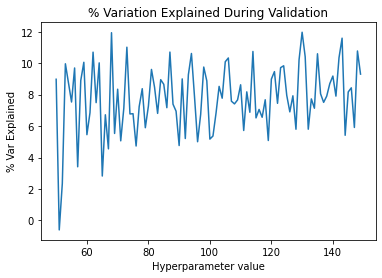

In [790]:
randomforest_tweak('n_estimators', 50, 150)

There's just a ton of variance in the explanatory power of the Random Forest model. No matter how I tune the hyperparameters, I think the dataset is just too small. 

# Examining the Data Again
Now that I've tamed the data so far, time to introduce more messy data! What fun! 

Based on the three factors in wildfire patterns, I want to introduce...
1. A measure of climate 
2. A measure of terrain
3. A measure of fuel

Other factors that would be interesting include
4. Population density

For (1), I already have temperature and precipitation. I have *very* simple measures of these, but let's move on for now. 

For (2), I can use my terrain data from my natural amenities project!

For (3), I need to find some land cover metric for each county.

For (4), I can also use natural amenity data

# Introducing Terrain Data

In [791]:
nat = pd.read_csv('/Users/patricknorman/Documents/GitHub/metis-project-2/data/nat_amen_clean.csv')

In [792]:
topo = nat[['FIPS','TOPO']]
topo['FIPS'] = topo['FIPS'].iloc[:].apply(lambda x: str(x))
topo.shape

<ipython-input-792-9334269caf11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topo['FIPS'] = topo['FIPS'].iloc[:].apply(lambda x: str(x))


(3111, 2)

In [793]:
westcoast['FIPS'] = westcoast['FIPS-YEAR'].apply(lambda x: x[:5])
#westcoast.head()

In [794]:
westcoast = pd.merge(westcoast, topo, on = 'FIPS')

# Round 2: Using Topography, Temp, and Precip

In [795]:
# using one hot encoder on state column
cat_x = westcoast.loc[:, ['STATE']]
cat_y = westcoast.loc[:, 'FIRE_SIZE']

ohe = OneHotEncoder(drop='first',sparse=False)
ohe.fit(cat_x)
ohe_x = ohe.transform(cat_x)
columns = ohe.get_feature_names(['STATE'])
ohe_x_df = pd.DataFrame(ohe_x, columns = columns, index = cat_x.index)



# splitting data
x = westcoast[['temp', 'temp_rank', 'temp_anomaly', 'temp_mean', 'precip',
       'precip_rank', 'precip_anomaly', 'precip_mean']]

# inserting ohe data
x = pd.concat([x,ohe_x_df], axis=1)

y = westcoast['FIRE_SIZE']

x_train_val, x_test, y_train_val, y_test = train_test_split(x,y,test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2)



In [796]:
# lets run a few RF models and take the average validation explanatory power

train_scores = []
val_scores = []
for i in range(10):
    

    rf_one = RandomForestRegressor(n_estimators = 100, max_depth = 20)

    rf_one.fit(x_train, y_train)

    rf_one_predictions = rf_one.predict(x_val)

    # print(round(rf_one.score(x_train, y_train)*100,2),'% variation explained during training.')
    # print(round(explained_variance_score(y_val, rf_one_predictions)*100,2),'% variation explained during validation.')

    train_scores.append(rf_one.score(x_train, y_train))
    val_scores.append(explained_variance_score(y_val, rf_one_predictions))
    
print(round(np.mean(train_scores)*100,2),'% variation explained during training.')
print(round(np.mean(val_scores)*100,2),'% variation explained during validation.')


85.64 % variation explained during training.
17.77 % variation explained during validation.


Nice! Including terrain improved my explanatory power by around 10%. 

# Introducing Population Density Data

In [797]:
nat.columns

Index(['FIPS', 'COMBINED_COUNTY_INDEX', 'STATE', 'COUNTY', 'CENSUS_DIV', 'RUC',
       'UIC', 'JAN_TEMP', 'JAN_SUN', 'JULY_TEMP', 'HUMIDITY', 'TOPO', 'WATER',
       'LN_WATER', 'JAN TEMP - Z', 'JAN SUN - Z', 'JUL TEMP - Z',
       'JUL HUM - Z', 'TOPOG - Z', 'LN WATER  AREA - Z', 'NAT_AMENITY',
       'RANK'],
      dtype='object')

In [798]:
pop_density = pd.read_pickle('/Users/patricknorman/Documents/python/nat.pkl')
pop_density = pop_density[['FIPS','DENSITY']]
pop_density['FIPS'] = pop_density['FIPS'].apply(lambda x: str(x))

In [799]:
pop_density

,FIPS,DENSITY
0,1003,137.0
1,1055,190.0
2,1069,170.0
3,1073,590.0
4,1077,130.0
...,...,...
439,55135,69.0
440,55141,92.0
441,56005,9.6
442,56007,2.0


In [800]:
westcoast.STATE.value_counts()

WA    702
OR    648
UT    522
NV    306
Name: STATE, dtype: int64

In [801]:
westcoast = pd.merge(westcoast, pop_density, on = 'FIPS')

In [802]:
westcoast.STATE.value_counts()

WA    216
OR    126
NV     18
UT     18
Name: STATE, dtype: int64

# Remember to apply standardscaler! The features are all scaled differently...

In [803]:
ss = StandardScaler()

x_scaled = ss.fit_transform(x)
x_train_val_scaled = ss.transform(x_train_val)
x_train_scaled = ss.transform(x_train)
x_val_scaled = ss.transform(x_val)
x_test_scaled = ss.transform(x_test)

In [804]:
train_scores = []
val_scores = []
for i in range(10):
    

    rf_one = RandomForestRegressor(n_estimators = 100, max_depth = 20)

    rf_one.fit(x_train, y_train)

    rf_one_predictions = rf_one.predict(x_val)

    # print(round(rf_one.score(x_train, y_train)*100,2),'% variation explained during training.')
    # print(round(explained_variance_score(y_val, rf_one_predictions)*100,2),'% variation explained during validation.')

    train_scores.append(rf_one.score(x_train, y_train))
    val_scores.append(explained_variance_score(y_val, rf_one_predictions))
    
print(round(np.mean(train_scores)*100,2),'% variation explained during training.')
print(round(np.mean(val_scores)*100,2),'% variation explained during validation.')


86.05 % variation explained during training.
16.22 % variation explained during validation.


A little better. Now let's try and introduce a measure of fuel abundance per county. I was able to find some sort of coarse woody debris (CWD) data per county. It's just from one year, but let's see if it adds some understanding. 

# Adding CWD Data

In [805]:
ca_cwd = pd.read_csv('/Users/patricknorman/Downloads/CA_DWM_COARSE_WOODY_DEBRIS.csv')

/Users/patricknorman/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [806]:
ca_cwd.head()

,CN,PLT_CN,INVYR,STATECD,COUNTYCD,PLOT,SUBP,TRANSECT,CWDID,MEASYEAR,...,LENGTH_CD,VOLCF_AC_UNADJ,VOLCF_AC_PLOT,VOLCF_AC_COND,DRYBIO_AC_UNADJ,DRYBIO_AC_PLOT,DRYBIO_AC_COND,CARBON_AC_UNADJ,CARBON_AC_PLOT,CARBON_AC_COND
0,722998001290487,558626849126144,2019,6,63,94358,2,180,2,2019,...,1.0,332.583509,332.583509,332.583509,5828.124239,5828.124239,5828.124239,3036.452729,3036.452729,3036.452729
1,722998002290487,558626849126144,2019,6,63,94358,2,180,3,2019,...,1.0,49.070577,49.070577,49.070577,532.482493,532.482493,532.482493,277.423379,277.423379,277.423379
2,722998003290487,558626849126144,2019,6,63,94358,2,180,4,2019,...,1.0,195.114565,195.114565,195.114565,2117.258388,2117.258388,2117.258388,1103.091620,1103.091620,1103.091620
3,722998004290487,558626849126144,2019,6,63,94358,2,180,5,2019,...,1.0,195.831799,195.831799,195.831799,2125.041353,2125.041353,2125.041353,1107.146545,1107.146545,1107.146545
4,722998005290487,558626849126144,2019,6,63,94358,2,360,1,2019,...,1.0,49.070577,49.070577,49.070577,532.482493,532.482493,532.482493,277.423379,277.423379,277.423379


In [807]:
ca_cwd.shape

(68817, 55)

In [808]:
ca_cwd.columns

Index(['CN', 'PLT_CN', 'INVYR', 'STATECD', 'COUNTYCD', 'PLOT', 'SUBP',
       'TRANSECT', 'CWDID', 'MEASYEAR', 'CONDID', 'SLOPDIST', 'HORIZ_DIST',
       'SPCD', 'DECAYCD', 'TRANSDIA', 'SMALLDIA', 'LARGEDIA', 'LENGTH',
       'HOLLOWCD', 'CWDHSTCD', 'VOLCF', 'DRYBIO', 'CARBON', 'COVER_PCT',
       'LPA_UNADJ', 'LPA_PLOT', 'LPA_COND', 'LPA_UNADJ_RGN', 'LPA_PLOT_RGN',
       'LPA_COND_RGN', 'COVER_PCT_RGN', 'CHARRED_CD', 'ORNTCD_PNWRS',
       'CREATED_BY', 'CREATED_DATE', 'CREATED_IN_INSTANCE', 'MODIFIED_BY',
       'MODIFIED_DATE', 'MODIFIED_IN_INSTANCE', 'CWD_SAMPLE_METHOD',
       'HOLLOW_DIA', 'HORIZ_DIST_CD', 'INCLINATION', 'LARGE_END_DIA_CLASS',
       'LENGTH_CD', 'VOLCF_AC_UNADJ', 'VOLCF_AC_PLOT', 'VOLCF_AC_COND',
       'DRYBIO_AC_UNADJ', 'DRYBIO_AC_PLOT', 'DRYBIO_AC_COND',
       'CARBON_AC_UNADJ', 'CARBON_AC_PLOT', 'CARBON_AC_COND'],
      dtype='object')

In [809]:
ca_cwd = ca_cwd[['INVYR','STATECD','COUNTYCD','COVER_PCT']]

In [810]:
ca_cwd.head()

,INVYR,STATECD,COUNTYCD,COVER_PCT
0,2019,6,63,0.886302
1,2019,6,63,0.340885
2,2019,6,63,0.681771
3,2019,6,63,0.681771
4,2019,6,63,0.340885


In [811]:
ca_cwd = ca_cwd.groupby(['COUNTYCD','INVYR']).mean()
ca_cwd = ca_cwd.reset_index()

In [812]:
type(ca_cwd.COUNTYCD.iloc[0])

numpy.int64

In [813]:
def county_processor(code):
    while len(code) < 3:
        code = '0'+ code
        
    return code

ca_cwd['COUNTYCD'] = ca_cwd['COUNTYCD'].apply(lambda x: county_processor(str(x)))

ca_cwd['COUNTYCD']

0      001
1      001
2      001
3      001
4      001
      ... 
878    115
879    115
880    115
881    115
882    115
Name: COUNTYCD, Length: 883, dtype: object

In [814]:
def cwd_preprocessor(path):
    '''
    This function takes in a file path to a CSV of coarse woody 
    debris for a state, and does all the necessary cleaning and 
    preprocessing for insertion into my other dataframe.
    
    NOTE: this is a very simple application of cwd. I am collapsing
    the variation between years. Depending on if this improves my 
    model, I may go back and change this.
    
    path (str): file path. 
    '''
    df = pd.read_csv(path)
    
    df = df[['STATECD','COUNTYCD','COVER_PCT']]
    
    df = df.groupby('COUNTYCD').mean()
    df = df.reset_index()
    
    df['STATECD'] = df['STATECD'].apply(lambda x: '0'+str(x))
    
    # quick function to add zeros to county codes
    def county_processor(code):
        while len(code) < 3:
            code = '0'+ code
        
        return code
    
    df['COUNTYCD'] = df['COUNTYCD'].apply(lambda x: county_processor(str(x)))
    
    df['FIPS'] = df['STATECD'] + df['COUNTYCD']
    
    df = df.drop(columns=['COUNTYCD','STATECD'])
    
    return df

In [815]:
ca_cwd = cwd_preprocessor('/Users/patricknorman/Downloads/CA_DWM_COARSE_WOODY_DEBRIS.csv')

/Users/patricknorman/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (19,33) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [816]:
ca_cwd.head()

,COVER_PCT,FIPS
0,0.286365,06001
1,0.441486,06003
2,0.477815,06005
3,0.324860,06007
4,0.375551,06009


In [817]:
ca_cwd.shape

(56, 2)

In [818]:
# california cwd
ca_cwd = cwd_preprocessor('/Users/patricknorman/Downloads/CA_DWM_COARSE_WOODY_DEBRIS.csv')



/Users/patricknorman/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (19,33) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [819]:
# oregon cwd

In [820]:
# washington cwd

In [821]:
# utah cwd

In [822]:
westcoast.STATE.value_counts()

WA    216
OR    126
NV     18
UT     18
Name: STATE, dtype: int64